# Este notebook, tem como objetivo:
    * Analisar a distribuição dos dados utilizados no modelo de conhecimento utilizado no AQ30M
    * Verificar a possibilidade de utilizar uma amostra de nao_queimada.
    * Analisar a distribuição do indice de NDVI nos conjuntos de queimada e nao_queimada e por orb_pto.
    * Realizar a classificação de uma passagem utilizando diversos tipos de modelo de conhecimento.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf

In [2]:
# Exibindo gráficos no output do notebook
%matplotlib inline

In [3]:
# Escolhe o estilo para os gráficos com o seaborn
sns.set_style('whitegrid')

In [4]:
# Configuração do iplotly
init_notebook_mode(connected=True)
cf.go_offline()

## Carrega dados

Neste CSV tem os dados históricos de 4 orb_pto, contendo apendas verifica 1 e 3:
    - 221_067
    - 221_070
    - 221_074
    - 226_070
**** Este dados, em algum momento foi verificado por alguem(autor desconhecido).

In [4]:
df = pd.read_csv('conhecimento.csv')
colunas = ['ndvi', 'nbrl', 'dif_ndvi', 'dif_dnbrl', 'medianb2', 'medianb3', 'medianb4', 'medianb5', 'medianb6', 'medianb7']

## Separa em 2 sub-conjuntos(queimadas e nao_queimadas)
    * Foi alterado o label de verifica para textual, facilitando o uso de alguns gráficos do seaborn que confunde o dado inteiro como feature e não como metadado

In [5]:
df['verifica'] = df.verifica.apply(lambda x: 'queimada' if x == 1 else 'nao_queimada')
df1 = df[df.verifica=='queimada'] # queimada
df3 = df[df.verifica=='nao_queimada'] # nao queimada

# Estatistica descritiva dos conjuntos

In [6]:
print('QUEIMADA')
df1.describe()

QUEIMADA


ndvi           nbrl       dif_ndvi      dif_dnbrl  \
count  113184.000000  113184.000000  113184.000000  113184.000000   
mean        0.226356       0.011152       0.173211       0.248001   
std         0.059957       0.079079       0.094378       0.119682   
min        -0.507201      -0.753977      -0.065708       0.000000   
25%         0.185310      -0.039758       0.106120       0.160890   
50%         0.224413       0.009293       0.155019       0.221400   
75%         0.266749       0.061435       0.215183       0.296315   
max         0.542561       0.431150       0.787095       1.205911   

            medianb2       medianb3       medianb4       medianb5  \
count  113184.000000  113184.000000  113184.000000  113184.000000   
mean        0.109385       0.099383       0.117826       0.188681   
std         0.017468       0.022776       0.032972       0.048024   
min         0.066379       0.045448       0.032622       0.016253   
25%         0.098669       0.084960       0.096125       0.158214   
50%         0.106015       0.096094       0.114774       0.188654   
75%         0.116183       0.109124       0.135411       0.217144   
max         0.784851       0.743309       0.792964       0.921527   

            medianb6       medianb7            id  
count  113184.000000  113184.000000  1.131840e+05  
mean        0.621125       0.185466  4.416280e+06  
std         3.434797       0.056094  2.280954e+06  
min         0.005842       0.008838  2.101400e+04  
25%         0.192681       0.148901  2.373944e+06  
50%         0.233781       0.183199  4.384632e+06  
75%         0.274958       0.218364  6.991396e+06  
max        38.582066       1.536971  7.564726e+06

In [7]:
print('NAO_QUEIMADA')
des_3 = df3.describe()
des_3

NAO_QUEIMADA


ndvi           nbrl       dif_ndvi      dif_dnbrl  \
count  275367.000000  275367.000000  275367.000000  275367.000000   
mean        0.314787       0.174871       0.233534       0.290336   
std         0.086081       0.095718       0.096030       0.110302   
min        -0.621544      -0.749672      -0.126101      -0.005284   
25%         0.254206       0.110873       0.157720       0.204120   
50%         0.310063       0.170081       0.223624       0.280369   
75%         0.376879       0.237938       0.299479       0.359452   
max         0.639127       0.582693       0.756723       0.922058   

            medianb2       medianb3       medianb4       medianb5  \
count  275367.000000  275367.000000  275367.000000  275367.000000   
mean        0.145918       0.143685       0.156234       0.294951   
std         0.041950       0.045670       0.050521       0.065975   
min         0.068000       0.044790       0.030617       0.014229   
25%         0.110990       0.107108       0.118811       0.249108   
50%         0.138607       0.138634       0.150966       0.290510   
75%         0.173645       0.172470       0.184431       0.338610   
max         0.768113       0.748524       0.777741       0.844699   

            medianb6       medianb7            id  
count  275367.000000  275367.000000  2.753670e+05  
mean        0.424857       0.209078  3.601712e+06  
std         1.540715       0.058452  1.940034e+06  
min        -3.488903       0.004941  1.752800e+04  
25%         0.256897       0.168728  2.196236e+06  
50%         0.296199       0.201991  3.455528e+06  
75%         0.346243       0.243720  4.731056e+06  
max        32.051437       1.188263  7.569192e+06

## Verificando a possibilidade de trabalhar com uma amostra e não a população de NAO_QUEIMADA
    * Esta tentativa esta sendo testa devido ao fato de existir um grande número dado de nao_queimada.
    * O script abaixo esta criando uma variável df3_amostra, que tem uma amostra aleatória de nao_queimada, com a mesma quantidade do conjunto de queimada

In [8]:
def gera_amostra_aleatoria(df_menor, df_maior):    
    ids_maior = np.random.choice(df_maior.id, len(df_menor), replace=False)
    return df_maior[df_maior.id.isin(ids_maior)].copy().reset_index(drop=True)
    
df3_amostra = gera_amostra_aleatoria(df1, df3)

## Estatistica descritiva dos dados da amosta de nao_queimada

In [9]:
print('AMOSTRA')
des_3_amostra = df3_amostra.describe()
des_3_amostra

AMOSTRA


ndvi           nbrl       dif_ndvi      dif_dnbrl  \
count  113184.000000  113184.000000  113184.000000  113184.000000   
mean        0.314611       0.174725       0.233568       0.290315   
std         0.086119       0.095621       0.096109       0.110490   
min        -0.493988      -0.309989       0.000000       0.000000   
25%         0.253682       0.110687       0.157664       0.203817   
50%         0.309799       0.169952       0.223800       0.280034   
75%         0.376793       0.237472       0.299291       0.359599   
max         0.631872       0.574695       0.756723       0.830252   

            medianb2       medianb3       medianb4       medianb5  \
count  113184.000000  113184.000000  113184.000000  113184.000000   
mean        0.145880       0.143674       0.156233       0.294892   
std         0.041889       0.045641       0.050468       0.065926   
min         0.068000       0.044790       0.030617       0.015253   
25%         0.110982       0.107077       0.118880       0.249019   
50%         0.138713       0.138830       0.151022       0.290443   
75%         0.173623       0.172486       0.184518       0.338596   
max         0.768113       0.748524       0.777741       0.844699   

            medianb6       medianb7            id  
count  113184.000000  113184.000000  1.131840e+05  
mean        0.420561       0.209081  3.595965e+06  
std         1.509754       0.058284  1.945178e+06  
min         0.006671       0.005370  1.767000e+04  
25%         0.256823       0.168821  2.195726e+06  
50%         0.296210       0.202112  3.455078e+06  
75%         0.346451       0.244007  4.730918e+06  
max        32.051437       0.624952  7.569181e+06

## Diferença entre os dados descritivos dos 2 conjuntos
Na tabela abaixo, mostra que a diferença entre os 2 conjuntos é muito pequena, muito próximo do zero. 
Indicando que podemos usar uma amostra aleatória ao invés da população de nao_queimada

In [10]:
diferenca_amostra_populacao_descricao = des_3 - des_3_amostra
diferenca_amostra_populacao_descricao

ndvi           nbrl       dif_ndvi      dif_dnbrl  \
count  162183.000000  162183.000000  162183.000000  162183.000000   
mean        0.000176       0.000147      -0.000033       0.000020   
std        -0.000038       0.000097      -0.000079      -0.000188   
min        -0.127556      -0.439684      -0.126101      -0.005284   
25%         0.000524       0.000186       0.000056       0.000304   
50%         0.000264       0.000128      -0.000176       0.000335   
75%         0.000086       0.000466       0.000188      -0.000147   
max         0.007255       0.007998       0.000000       0.091807   

            medianb2       medianb3       medianb4       medianb5  \
count  162183.000000  162183.000000  162183.000000  162183.000000   
mean        0.000038       0.000010       0.000001       0.000059   
std         0.000061       0.000029       0.000054       0.000049   
min         0.000000       0.000000       0.000000      -0.001024   
25%         0.000008       0.000032      -0.000069       0.000089   
50%        -0.000106      -0.000197      -0.000056       0.000068   
75%         0.000022      -0.000016      -0.000087       0.000015   
max         0.000000       0.000000       0.000000       0.000000   

            medianb6       medianb7             id  
count  162183.000000  162183.000000  162183.000000  
mean        0.004295      -0.000002    5746.992043  
std         0.030961       0.000168   -5144.057569  
min        -3.495575      -0.000429    -142.000000  
25%         0.000073      -0.000093     509.750000  
50%        -0.000012      -0.000121     450.500000  
75%        -0.000209      -0.000287     139.000000  
max         0.000000       0.563311      11.000000

## Histograma de atributos para compara os conjuntos de nao_queimada

Pode ser observado nos gráficos que a amostra representa a população de nao_queimada, onde ambas estção distribuindo seus valores em intervalos parecidos e com a concentração de dados no mesmo local(linha mediana)

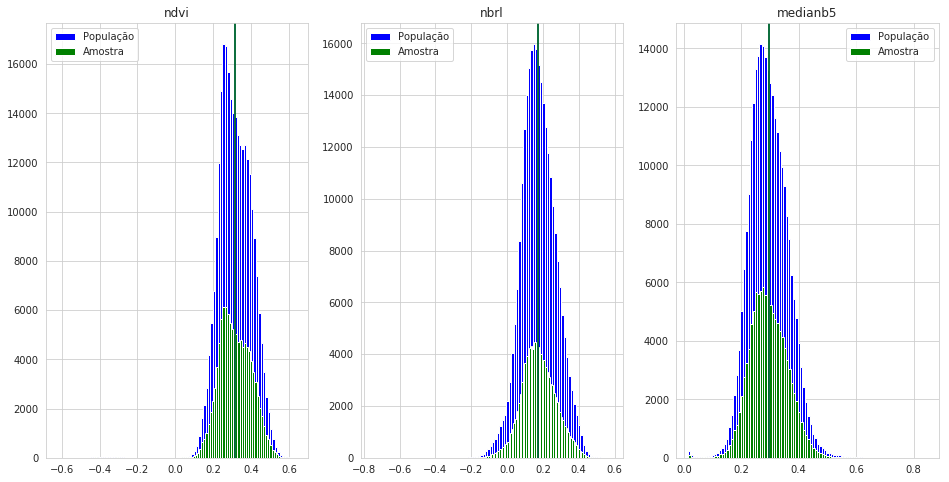

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,8))
# hist
plt.subplot(1, 3, 1)
plt.title('ndvi')
eixo = df3.ndvi.hist(bins=100, facecolor='b', label='População')
eixo = df3_amostra.ndvi.hist(bins=100, facecolor='g', label='Amostra')
eixo.axvline(df3.ndvi.mean(), c='b')
eixo.axvline(df3_amostra.ndvi.mean(), c='g')
plt.legend()

plt.subplot(1, 3, 2)
plt.title('nbrl')
eixo = df3.nbrl.hist(bins=100, facecolor='b', label='População')
eixo = df3_amostra.nbrl.hist(bins=100, facecolor='g', label='Amostra')
eixo.axvline(df3.nbrl.mean(), c='b')
eixo.axvline(df3_amostra.nbrl.mean(), c='g')
plt.legend()

plt.subplot(1, 3, 3)
plt.title('medianb5')
eixo = df3.medianb5.hist(bins=100, facecolor='b', label='População')
eixo = df3_amostra.medianb5.hist(bins=100, facecolor='g', label='Amostra')
eixo.axvline(df3.medianb5.mean(), c='b')
eixo.axvline(df3_amostra.medianb5.mean(), c='g')
plt.legend()

# Compara média e distribuição do NDVI dos conjuntos de QUEIMADA e NAO_QUEIMADA e AMOSTRA_NAO_QUEIMADA

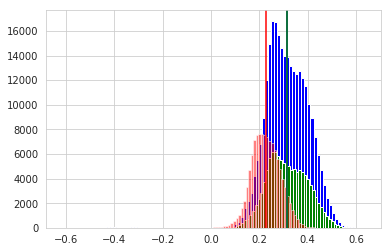

In [12]:
df3.ndvi.hist(bins=100, facecolor='b')
df3_amostra.ndvi.hist(bins=100, facecolor='g')
ax = df1.ndvi.hist(bins=100, facecolor='r', alpha=0.5)
ax.axvline(df1.ndvi.mean(), c='r')
ax.axvline(df3.ndvi.mean(), c='b')
ax.axvline(df3_amostra.ndvi.mean(), c='g')

# Compara distribuição de NDVI em orb_pto diferentes

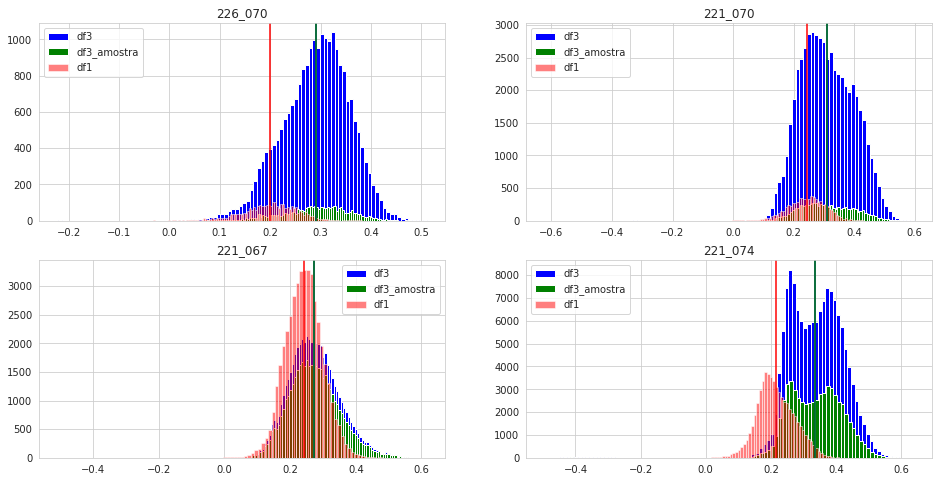

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
# hist

for k, op in enumerate(df.orb_pto.unique()):
    plt.subplot(2, 2, k+1)
    plt.title(op)
    temp1 = df1[df1.orb_pto==op]
    temp3 = df3[df3.orb_pto==op]
    temp3_amostra = gera_amostra_aleatoria(temp1, temp3)
    temp3.ndvi.hist(bins=100, facecolor='b', label='df3')
    temp3_amostra.ndvi.hist(bins=100, facecolor='g', label='df3_amostra')
    ax = temp1.ndvi.hist(bins=100, facecolor='r', alpha=0.5, label='df1')
    ax.axvline(temp1.ndvi.mean(), c='r')
    ax.axvline(temp3.ndvi.mean(), c='b')
    ax.axvline(temp3_amostra.ndvi.mean(), c='g')
    plt.legend()


# Lista todas cenas de uma orb_pto de um determinado ano
Neste exemplo, esta sendo filtrado os ID_CENAs da orb_pto 221_067 do ano de 2017

# * Apartir deste ponto, os dados observados serão somentes desta orb_pto/ano

In [14]:
df_221_067 = df[df.id_cena.str.contains('2210672017')]
id_cenas = sorted(df_221_067.id_cena.unique())
id_cenas

['LS82210672017125',
 'LS82210672017141',
 'LS82210672017157',
 'LS82210672017173',
 'LS82210672017189',
 'LS82210672017205',
 'LS82210672017221',
 'LS82210672017237',
 'LS82210672017253',
 'LS82210672017269',
 'LS82210672017285']

## Histograma NDVI e NBRL de cada passagem

    * Esta sendo plotado, a curva de densidade de queimada e nao_queimada
    * A amostra de nao_queimada não esta sendo gerada. Nesta orb_pto, o conjunto de queimada é maior que nao_queimada

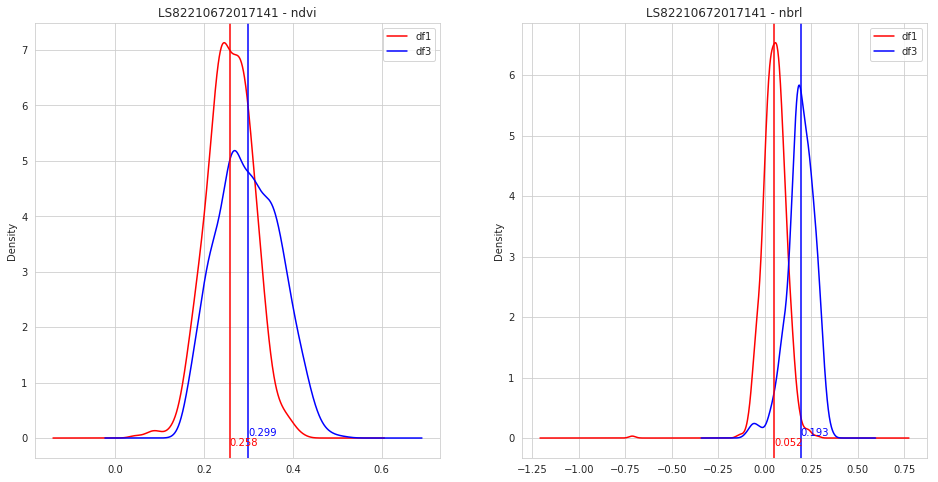

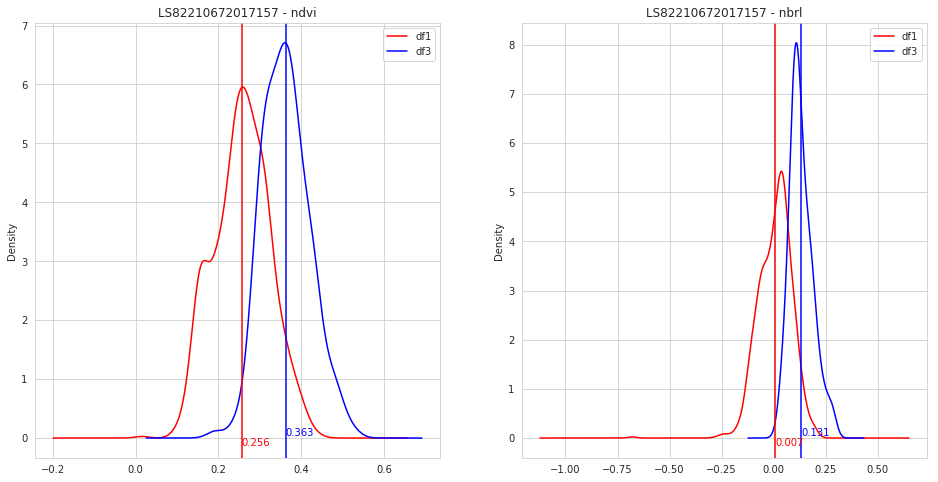

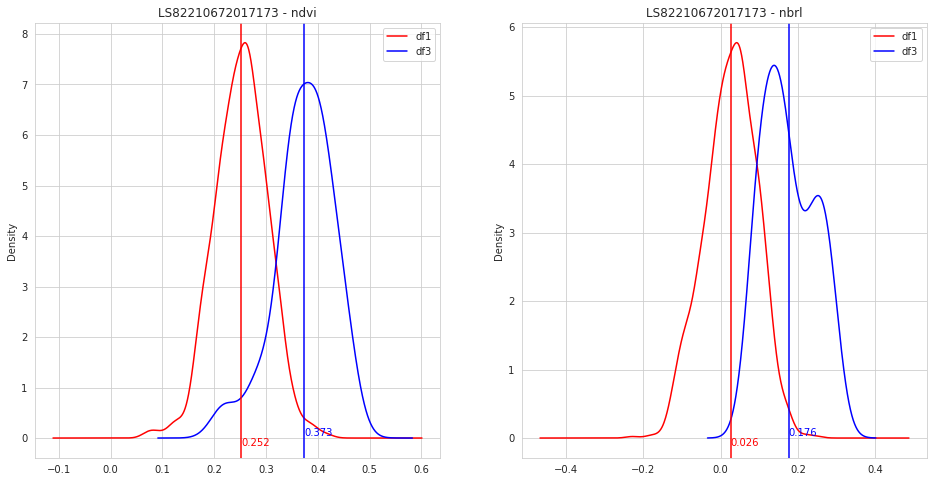

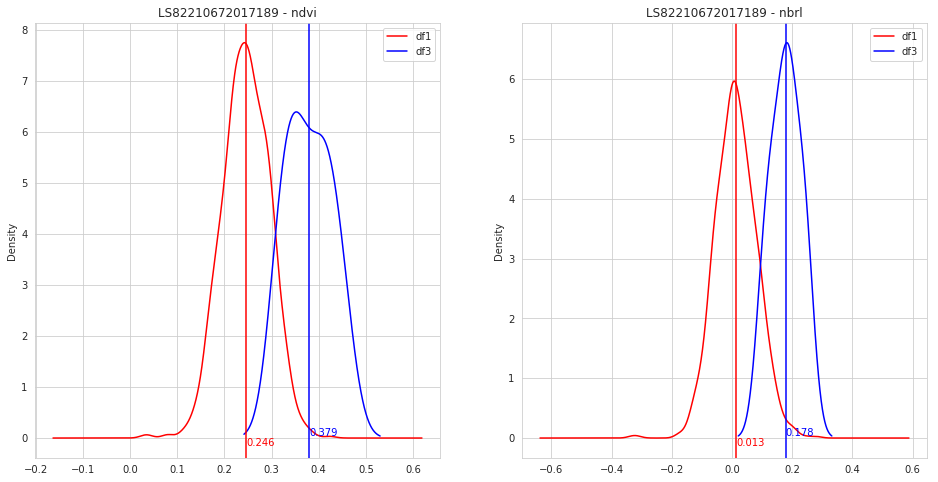

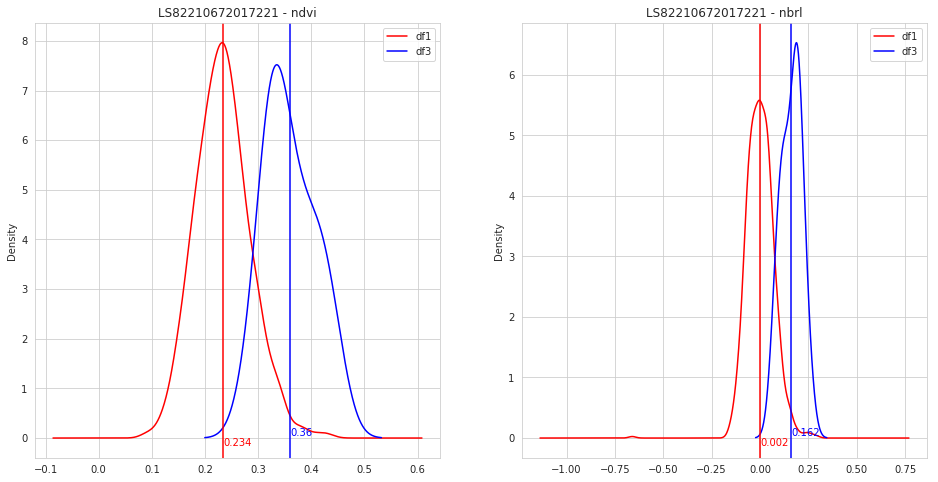

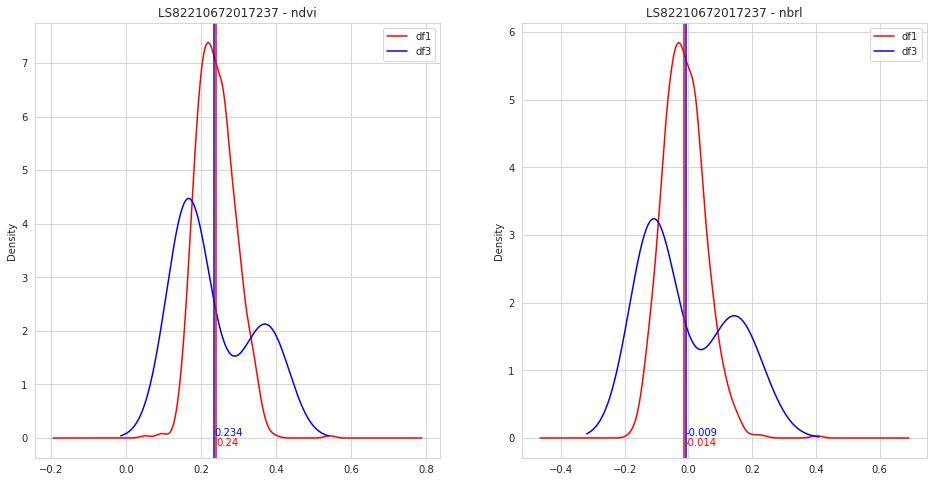

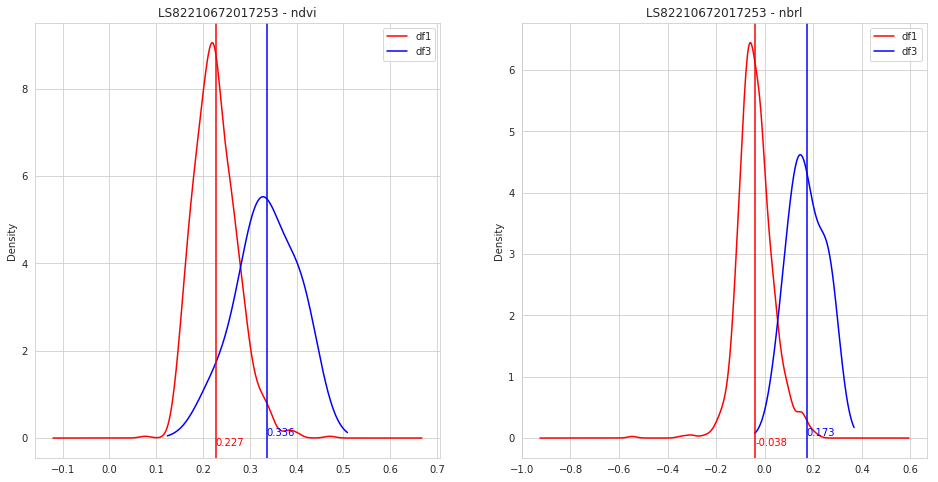

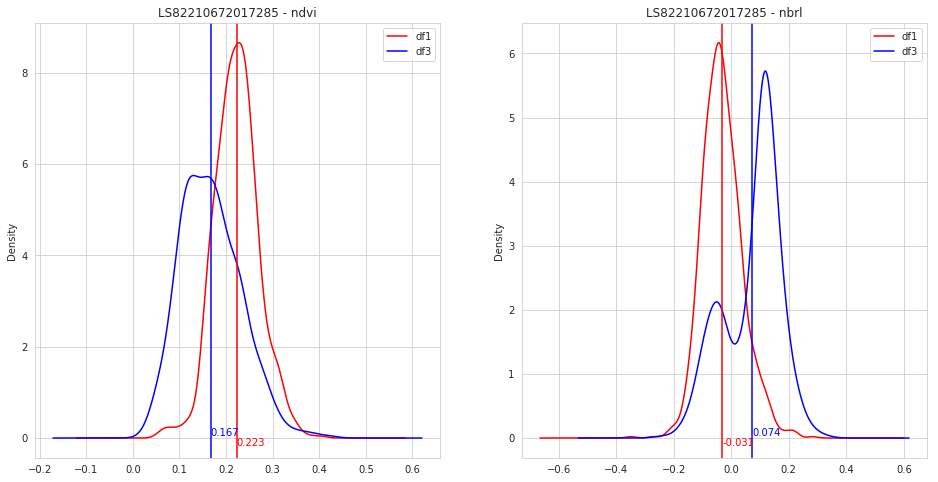

In [15]:
for i in id_cenas:
    fig, ax = plt.subplots(figsize=(16,8))
    d = df[df.id_cena==i].copy()
    d1 = d[d.verifica=='queimada']
    d3 = d[d.verifica=='nao_queimada']
    
    col = 'ndvi'
    plt.subplot(1, 2, 1)
    plt.title('%s - %s' % (i, col))
    ax = d1[col].plot.kde(c='r', label='df1')
    d3[col].plot.kde(c='b', label='df3')
    plt.axvline(d1[col].mean(), c='r')
    plt.axvline(d3[col].mean(), c='b')
    ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')
    ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
    plt.legend()
    
    col = 'nbrl'
    plt.subplot(1, 2, 2)
    plt.title('%s - %s' % (i, col))
    ax = d1[col].plot.kde(c='r', label='df1')
    d3[col].plot.kde(c='b', label='df3')
    plt.axvline(d1[col].mean(), c='r')
    plt.axvline(d3[col].mean(), c='b')
    ax.text(d1[col].mean(), 0, round(d1[col].mean(),3), color='r', verticalalignment='top')
    ax.text(d3[col].mean(), 0, round(d3[col].mean(),3), color='b', verticalalignment='bottom')
    plt.legend()

# Graficos cruzando as combinações de colunas

In [16]:
paleta_cores = {'queimada': 'red', 'nao_queimada': 'blue'}

In [17]:
sns.pairplot(df_221_067[colunas+['verifica']], hue='verifica', palette=paleta_cores)

# Boxplot: Neste gráfico, tem 50% dos dados na parte colorida, e 25%+- nas extremidades. Os pontos mais externos são considerados outliers

In [18]:
plt.title('ndvi')
sns.boxplot(data=df_221_067,x='verifica', y='ndvi', palette=paleta_cores)

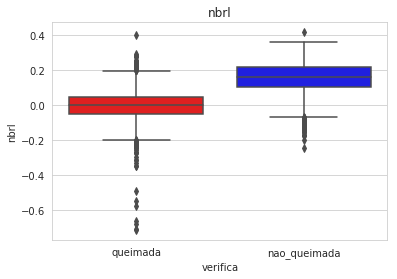

In [19]:
plt.title('nbrl')
sns.boxplot(data=df_221_067,x='verifica', y='nbrl', palette=paleta_cores)

# Regressão linear

/home/queimadas/.conda/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



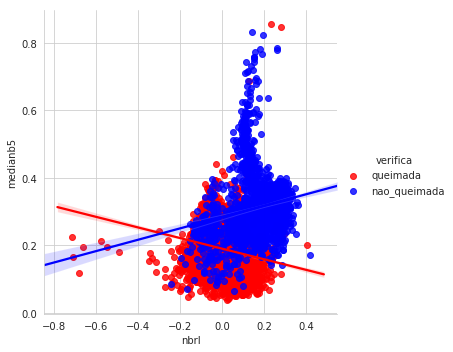

In [90]:
sns.lmplot(x='nbrl', y='medianb5', data=df_221_067, hue='verifica', palette=paleta_cores)

# Correlação

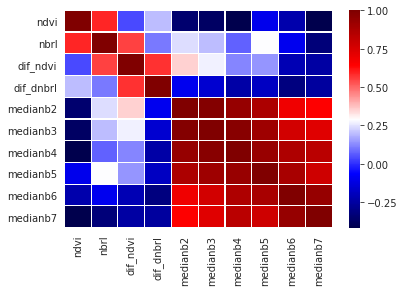

In [88]:
correlacao = df_221_067[colunas].corr()
sns.heatmap(correlacao, cmap='seismic', linecolor='white', linewidths=0.1)

In [13]:
id_cena = 'LS82210672017141'

## Remove cena selecionada do conhecimento

In [14]:
modelo = modelo[(modelo.id_cena!=id_cena)]

In [15]:
print(len(modelo))

95252


## Pega dados para classificar

In [16]:
# Dado que será classificado
teste = df[df.id_cena==id_cena].copy().reset_index(drop=True)

In [17]:
print(len(teste))

1810


In [18]:
print(teste.verifica.value_counts())

3    1091
1     719
Name: verifica, dtype: int64


## Cria classificador com Random Forest

In [20]:
classificador = RandomForestClassifier(n_jobs=8, n_estimators=100, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=8,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## Coeficiente GINI
GINI é um indice para definir a desigualdade, criado por um italiano estatistico, variando o valor de 0 a 1, onde:


    - Próximo de 0: Igualdade
    - Próximo de 1: Desigualdade

Para diferenciar dado de AREA_QUEIMADA e de NAO_AREA_QUEIMADA, é mais importante que ocorra a DESIGUALDADE, para que possa ter diferença significativa entre si dentro do mesmo conjunto de dado.

In [21]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

coluna      gini
0   medianb5  0.737022
1       nbrl  0.237386
2   medianb2  0.024019
3   dif_ndvi  0.001121
4   medianb3  0.000452
5       ndvi  0.000000
6  dif_dnbrl  0.000000
7   medianb4  0.000000
8   medianb6  0.000000
9   medianb7  0.000000

In [22]:
## Classifica usando usanfo Random Forest e usando todas colunas

In [23]:
teste['rf'] = classificador.predict(teste[colunas])

## Verifica resultado da classificação

In [24]:
def ver_resultado(dado, coluna_previsao, coluna_verdade):
    try:
        quantidade_acerto_verifica_1 = len(dado[(dado[coluna_previsao]==1) & (dado[coluna_verdade]==1)])
        total_veirifica1 = len(dado[dado[coluna_verdade]==1])
        porcentagem = int((quantidade_acerto_verifica_1*100)/total_veirifica1)
        resultado = pd.DataFrame(data=[
            [len(dado), total_veirifica1, quantidade_acerto_verifica_1, porcentagem]
        ],
            columns=['total_features', 'total_verifica_1', 'acertos_verifica_1', 'porcentagem_acerto']
        )
        return resultado
    except Exception as e:
        print(e)
        return e
        return [0, 0, 0]

In [25]:
ver_resultado(teste, 'rf', 'verifica')

total_features  total_verifica_1  acertos_verifica_1  porcentagem_acerto
0            1810               719                 677                  94

## Testando com um modelo gerado com uma amostra de verifica 1 e 3 em mesma quantidade

In [26]:
modelo = df[df.id_cena.isin(id_cenas)] # Modelo com todas cenas da mesma orb_pto
modelo = modelo[(modelo.id_cena!=id_cena)] # Remove a cena atual do conhecimento

modelo_inteiro_1 = modelo[modelo.verifica==1]
modelo_inteiro_3_full = modelo[modelo.verifica==3]

if len(modelo_inteiro_3_full) > len(modelo_inteiro_1):
    id3 = np.random.choice(modelo_inteiro_3_full.id, len(modelo_inteiro_1), replace=False) 
    modelo_inteiro_3 = modelo_inteiro_3_full[modelo_inteiro_3_full.id.isin(id3)]
else:
    print('Existe mais verifica 1 do que 3')
    modelo_inteiro_3 = modelo_inteiro_3_full
    id1 = np.random.choice(modelo_inteiro_1.id, len(modelo_inteiro_3), replace=False) 
    modelo_inteiro_1 = modelo_inteiro_1[modelo_inteiro_1.id.isin(id1)]

modelo = pd.concat([modelo_inteiro_1, modelo_inteiro_3]).reset_index(drop=True)

In [27]:
modelo.verifica.value_counts()

3    42089
1    42089
Name: verifica, dtype: int64

## Cria classificador com Random Forest

In [28]:
classificador = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## Indice GINI

In [29]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

coluna      gini
0   medianb2  0.716854
1       nbrl  0.122547
2   medianb5  0.084111
3       ndvi  0.071179
4   medianb6  0.005129
5   dif_ndvi  0.000167
6   medianb3  0.000013
7  dif_dnbrl  0.000000
8   medianb4  0.000000
9   medianb7  0.000000

## Classifica com Random Forest

In [30]:
teste['rf'] = classificador.predict(teste[colunas])

## Verifica resultado da classificação

In [31]:
ver_resultado(teste, 'rf', 'verifica')

total_features  total_verifica_1  acertos_verifica_1  porcentagem_acerto
0            1810               719                 687                  95

## Testando com um modelo usando o trimestre histórico da orb_pto

In [32]:
orb_pto = '221_067'
modelo = df[df.orb_pto==orb_pto] # Modelo com todas cenas da mesma orb_pto
modelo = modelo[(modelo.id_cena!=id_cena)] # Remove a cena atual do conhecimento

In [33]:
classificador = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

# GINI

In [34]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

coluna      gini
0   medianb2  0.596928
1       nbrl  0.194765
2   medianb5  0.176041
3       ndvi  0.028509
4   medianb6  0.002011
5   dif_ndvi  0.001746
6  dif_dnbrl  0.000000
7   medianb3  0.000000
8   medianb4  0.000000
9   medianb7  0.000000

In [ ]:
# Classificação

In [35]:
teste['rf'] = classificador.predict(teste[colunas])

In [36]:
ver_resultado(teste, 'rf', 'verifica')

total_features  total_verifica_1  acertos_verifica_1  porcentagem_acerto
0            1810               719                 676                  94